# LSTM vs LGBM for single-step predictions

In this notebook we compare the performance of our best LSTM with a lightgbm regressor for predicting the points scored in the next gameweek (i.e. a single timestep).

## Set-up

In [1]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
from keras.layers import \
    Dense, \
    LSTM, \
    BatchNormalization, \
    Dropout, \
    Activation
from keras import \
    initializers, \
    optimizers, \
    Sequential
from hyperopt import hp, fmin, rand, tpe, Trials
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 42

## Load training data

In [6]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [7]:
all_data = load_all_data()

2020-06-08 22:51:40,082 - Loading raw historical FPL data
2020-06-08 22:51:40,349 - Creating season order column
2020-06-08 22:51:40,356 - Generating known features for next GW


In [8]:
print(all_data.shape)
all_data.head()

(67797, 68)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

### Create target

In [10]:
all_data['total_points_plus1_gw'] = all_data.groupby(['name'])['total_points'].shift(-1)
all_data = all_data[~all_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Train/dev/test split

We now added a random_state parameter to `custom_train_test_split` to ensure consistent training sets

In [11]:
training_df, test_df = custom_train_test_split(all_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)

Proportion in test set: 0.09869880673982132
Test set size: (6584, 70)
Training set size: (60124, 70)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.10238839731222141
Test set size: (6156, 70)
Training set size: (53968, 70)


In [13]:
print(f"Proportion training: {training_df.shape[0]/all_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/all_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/all_data.shape[0]}")

Proportion training: 0.8090184085866763
Proportion dev: 0.09228278467350243
Proportion test: 0.09869880673982132


We now get a close 80/10/10 split

In [14]:
mms = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

### Filter out ineligible players

In [15]:
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [16]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [17]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

In [18]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [19]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(45691, 5, 63)
(45691, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(4995, 5, 63)
(4995, 5)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5355, 5, 63)
(5355, 5)


## LSTM model

Load best model architecture

In [20]:
from src.models.LSTM.bayes_hyperparameter_search import create_model

In [21]:
colab_trials_dict = pickle.load(open('src/models/pickles/colab_trials_dict.pickle', 'rb'))

In [22]:
colab_trials_dict.keys()

dict_keys(['bayes_trials', 'best'])

In [23]:
bayes_trials = colab_trials_dict['bayes_trials']
best = colab_trials_dict['best']

In [24]:
best

{'batch_size': 527.0,
 'dense_dropout': 0.46,
 'dense_units': 25.0,
 'learning_rate': 0.0010974169408205815,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [25]:
hyperparams = best.copy()

In [26]:
fitting_params = {}
fitting_params['learning_rate'] = hyperparams['learning_rate']
fitting_params['batch_size'] = hyperparams['batch_size']

del hyperparams['learning_rate'], hyperparams['batch_size']

In [27]:
hyperparams

{'dense_dropout': 0.46,
 'dense_units': 25.0,
 'lstm_dropout': 0.02,
 'lstm_output_dropout': 0.03,
 'lstm_recurrent_dropout': 0.5,
 'lstm_units': 15.0,
 'n_dense_layers': 0.0,
 'n_lstm_layers': 1.0}

In [28]:
fitting_params

{'learning_rate': 0.0010974169408205815, 'batch_size': 527.0}

In [29]:
fitting_params['batch_size'] = int(fitting_params['batch_size'])

In [30]:
INTEGER_PARAMS = ['n_lstm_layers', 'lstm_units', 'n_dense_layers', 'dense_units', 'batch_size']

for hyper in INTEGER_PARAMS:
    try:
        as_int = int(hyperparams[hyper])
        hyperparams[hyper] = as_int
    except:
        continue

In [35]:
colab_model = create_model(n_steps_in=N_STEPS_IN, n_steps_out=N_STEPS_OUT, n_features=63, **hyperparams)

In [36]:
colab_model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_layer_1 (LSTM)          (None, 15)                4740      
_________________________________________________________________
lstm_layer_1_dropout (Dropou (None, 15)                0         
_________________________________________________________________
dense_output (Dense)         (None, 5)                 80        
Total params: 4,820
Trainable params: 4,820
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compile model
optimizer = optimizers.Adam(learning_rate=fitting_params['learning_rate'])
colab_model.compile(loss='mse', optimizer=optimizer)

In [38]:
# Fit model
colab_model.fit(X_train, y_train, batch_size=fitting_params['batch_size'], epochs=30, validation_data=(X_dev, y_dev))

Train on 45691 samples, validate on 4995 samples
Epoch 1/30
45691/45691 [==============================] - 2s 36us/step - loss: 6.6444 - val_loss: 7.6192
Epoch 2/30
45691/45691 [==============================] - 1s 26us/step - loss: 5.2712 - val_loss: 6.8170
Epoch 3/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.9930 - val_loss: 6.6655
Epoch 4/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.9025 - val_loss: 6.5936
Epoch 5/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8612 - val_loss: 6.5515
Epoch 6/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8338 - val_loss: 6.5177
Epoch 7/30
45691/45691 [==============================] - 1s 26us/step - loss: 4.8129 - val_loss: 6.5045
Epoch 8/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8047 - val_loss: 6.4894
Epoch 9/30
45691/45691 [==============================] - 1s 25us/step - loss: 4.8014 - val_loss: 6.4841
Epoch 

In [39]:
prediction_lstm = colab_model.predict(X_dev)
prediction_lstm.shape

(4995, 5)

In [40]:
prediction_lstm[:, :1]

array([[ 0.0641978 ],
       [-0.05815956],
       [ 0.00838789],
       ...,
       [ 1.1740205 ],
       [ 0.2239496 ],
       [ 0.36354005]], dtype=float32)

In [41]:
y_dev[:, :1]

array([[0.0],
       [0.0],
       [0.0],
       ...,
       [0.0],
       [0.0],
       [0.0]], dtype=object)

In [42]:
mean_squared_error(y_dev[:, :1], prediction_lstm[:, :1])

6.064538493140892

## LGBM

Train a lightgbm regressor using the features from a single gamewek to predict the next

In [65]:
X_train_lgbm = np.squeeze(X_train[:,:1,:], axis=1)
y_train_lgbm = np.squeeze(y_train[:,:1], axis=1)
X_dev_lgbm = np.squeeze(X_dev[:,:1,:], axis=1)

In [66]:
X_train_lgbm.shape

(45691, 63)

In [67]:
y_train_lgbm.shape

(45691,)

In [68]:
import lightgbm

In [69]:
lgbm_model = lightgbm.LGBMRegressor()

In [70]:
lgbm_model.fit(X_train_lgbm, y_train_lgbm)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [71]:
predictions_lgbm = lgbm_model.predict(X_dev_lgbm)

In [73]:
mean_squared_error(y_dev[:, :1], predictions_lgbm)

6.871341565786178

In [74]:
mean_squared_error(y_train[:, :1], lgbm_model.predict(X_train_lgbm))

4.182833664146814

In [77]:
mean_squared_error(y_train[:, :1], colab_model.predict(X_train)[:, :1])

4.378458847686254

__Comparison__

MSE LSTM: 6.064538493140892

MSE LGBM: 6.871341565786178

We're being a bit unfair to lightgbm as our LSTM architecture was the result of Bayes tuning whereas our lightgbm is out-of-the-box. Let's do random search to find a better lightgbm.

### Random search

In [78]:
from sklearn.model_selection import RandomizedSearchCV

In [88]:
PARAM_DISTRIBUTIONS = {
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.logspace(np.log10(0.01), np.log10(100), base=10, num=1000)),
    'reg_lambda': list(np.logspace(np.log10(0.01), np.log10(100), base=10, num=1000)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
}

In [98]:
lgbm_random = RandomizedSearchCV(
    lightgbm.LGBMRegressor(),
    param_distributions=PARAM_DISTRIBUTIONS,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [99]:
lgbm_random.fit(X_train_lgbm, y_train_lgbm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                                                      0.6212121212121212,
                                                      0.626262

In [100]:
predictions_lgbm = lgbm_random.predict(X_dev_lgbm)

In [101]:
mean_squared_error(y_dev[:, :1], predictions_lgbm)

6.719226873747672

__Comparison__

MSE LSTM: 6.064538493140892

MSE LGBM (out-of-the-box): 6.871341565786178

MSE LGBM (random search): 6.719226873747672

We're still being unfair to lightgbm as we are only using a single gameweek's worth of features whereas the LSTM uses 5 previous gameweeks. Let's feed the same data to lightgbm. Any performance gain from LSTM should be a result of it's ability to 'remember' useful features in the past.

### Random search and past 5 gameweek features

Reshape the data to get features for all 5 gameweeks on a single row

In [120]:
X_train_lgbm = np.reshape(X_train, (X_train.shape[0], -1))
y_train_lgbm = np.squeeze(y_train[:,:1], axis=1)  # as before
X_dev_lgbm = np.reshape(X_dev, (X_dev.shape[0], -1))

In [122]:
X_train_lgbm.shape

(45691, 315)

In [123]:
X_dev_lgbm.shape

(4995, 315)

In [146]:
lgbm_random = RandomizedSearchCV(
    lightgbm.LGBMRegressor(),
    param_distributions=PARAM_DISTRIBUTIONS,
    n_iter=200,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [147]:
lgbm_random.fit(X_train_lgbm, y_train_lgbm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 21.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...
                                                      0.6212121212121212,
                                                      0.626262

In [148]:
predictions_lgbm = lgbm_random.predict(X_dev_lgbm)

In [149]:
mean_squared_error(y_dev[:, :1], predictions_lgbm)

5.976896894513474

__Comparison__

MSE LSTM: 6.064538493140892

MSE LGBM (out-of-the-box): 6.871341565786178

MSE LGBM (random search): 6.719226873747672

MSE LGBM (random search and 5 GWs): 5.976896894513474

_LGBM does better than LSTM for the single time-step prediction! An interesting result!_

### Ensemble

Text(0, 0.5, 'LightGBM GW+1 predictions')

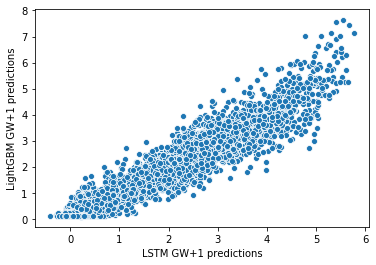

In [154]:
sns.scatterplot(x=np.squeeze(prediction_lstm[:, :1]), y=predictions_lgbm)
plt.xlabel('LSTM GW+1 predictions')
plt.ylabel('LightGBM GW+1 predictions')

Maybe the LSTM has been 'drowned' by the number of players who score 0 points and as such predicts lower values on average which has led to a worse MSE than LightGBM?

Maybe we can strip out these players before training our model.

In [155]:
ensemble_predictions = np.mean(
    np.array(
        [
            np.squeeze(prediction_lstm[:, :1]), 
            predictions_lgbm
        ]
    ),
    axis=0
)

In [156]:
ensemble_predictions.shape

(4995,)

In [157]:
mean_squared_error(y_dev[:, :1], ensemble_predictions)

5.9755796171182505

## Final comparison

MSE LSTM: 6.064538493140892

MSE LGBM (out-of-the-box): 6.871341565786178

MSE LGBM (random search): 6.719226873747672

MSE LGBM (random search and 5 GWs): 5.976896894513474

MSE Ensemble (LGBM (random search and 5 GWs) and LSTM): 5.9755796171182505

_Minor performance gain by ensembling the 2 models_

## Next steps

- Using LightGBM for single step predictions looks like a beneficial change and should be relatively straightforward to incorporate.
- We will refrain from using 5 LightGBM models (one for each timestep) due to the added burden of maintaining 5 models. Also suspect that LSTM will provide more robust predictions for future GWs as it can more easily find trends.
- Explore the benefits of using non-zero-points players to train our LSTM.
- Maybe our dataset is too imbalanced in this sense which is why it tends to be quite conservative in it's predictions.
- If we are to use data from Fantasy Football Scout we will only have data for players who played >0 minutes in a game.